In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image

/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A54E39C4-6B62-3303-9BE6-7DB88EB078BF> /opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 定义数据集类
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.load_dataset()

    def load_dataset(self):
        for label in ['class_0_normal', 'class_1_distressed']:
            class_dir = os.path.join(self.root_dir, label)
            for img_file in os.listdir(class_dir):
                if img_file.endswith('.png'):
                    self.image_files.append(os.path.join(class_dir, img_file))
                    self.labels.append(0 if 'normal' in label else 1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)
        image = image.convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [21]:
class ResNet50Trainer:
    def __init__(self, train_dir, test_dir, batch_size=32, learning_rate=0.001):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device("mps")
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # 修改最后的全连接层为2分类
        self.model = self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_loader = self.load_data(self.train_dir, train=True)
        self.test_loader = self.load_data(self.test_dir, train=False)
        self.history = {'train_loss': [], 'test_loss': [], 'test_accuracy': [], 'train_accuracy': []}
        self.best_acc = 0.0
        self.best_model = None
        self.y_true_train = []
        self.y_scores_train = []
        self.y_true_test = []
        self.y_scores_test = []

    def load_data(self, data_dir, train=True):
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
        transform = data_transforms['train'] if train else data_transforms['test']
        dataset = CustomDataset(data_dir, transform=transform)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=train)
        return dataloader

    def train(self, num_epochs=30):
        self.model.train()
        scheduler = CosineAnnealingLR(self.optimizer, T_max=10, eta_min=0, last_epoch=-1)

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for i, (images, labels) in enumerate(self.train_loader):
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                self.y_true_train.extend(labels.cpu().numpy())
                self.y_scores_train.extend(F.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())  # 使用detach()

                if (i+1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(self.train_loader)}], Loss: {running_loss / (i+1):.4f}')

            scheduler.step()
            epoch_loss = running_loss / len(self.train_loader.dataset)
            train_accuracy = 100 * correct_predictions / total_predictions
            self.history['train_loss'].append(epoch_loss)
            self.history['train_accuracy'].append(train_accuracy)

            self.validate()

        self.plot_loss()
        self.plot_acc()
        self.plot_roc_curve()

    def validate(self):
        self.model.eval()
        correct_predictions = 0
        total_predictions = 0
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                self.y_true_test.extend(labels.cpu().numpy())
                self.y_scores_test.extend(F.softmax(outputs, dim=1)[:, 1].cpu().numpy())

            test_loss /= len(self.test_loader.dataset)
            test_accuracy = 100 * correct_predictions / total_predictions
            if test_accuracy > self.best_acc:
                self.best_acc = test_accuracy
                self.best_model = self.model.state_dict()

            self.history['test_loss'].append(test_loss)
            self.history['test_accuracy'].append(test_accuracy)
            
            print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

    def save_best_model(self, savename='best_model.pth'):
        torch.save(self.best_model, savename)

    def test_with_best_model(self, savename='best_model.pth'):
        self.model.load_state_dict(torch.load(savename))
        self.model.eval()
        with torch.no_grad():
            y_true = []
            y_scores = []
            correct_predictions = 0
            total_predictions = 0

            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_scores.extend(probabilities[:, 1].cpu().numpy())

            test_accuracy = 100 * correct_predictions / total_predictions
            print(f'Test Acc: {test_accuracy:.2f}%')

        self.plot_roc_curve(y_true, y_scores)

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['test_loss'], label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss Over Epochs')
        plt.legend()
        plt.show()
    
    def plot_acc(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['train_accuracy'], label='Train Accuracy', color='blue')
        plt.plot(self.history['test_accuracy'], label='Test Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Test Accuracy Over Epochs')
        plt.legend()
        plt.show()
    
    def plot_roc_curve(self, y_true=None, y_scores=None):
        if y_true is None or y_scores is None:
            fpr_train, tpr_train, _ = roc_curve(self.y_true_train, self.y_scores_train)
            roc_auc_train = auc(fpr_train, tpr_train)
            fpr_test, tpr_test, _ = roc_curve(self.y_true_test, self.y_scores_test)
            roc_auc_test = auc(fpr_test, tpr_test)

            print(f'Train AUC: {roc_auc_train:0.4f}')
            print(f'Test AUC: {roc_auc_test:0.4f}')

            plt.figure()
            plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:0.2f})')
            plt.plot(fpr_test, tpr_test, color='orange', lw=2, label=f'Test ROC curve (area = {roc_auc_test:0.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
        else:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            print(f'Test AUC: {roc_auc:0.4f}')

            plt.figure()
            plt.plot(fpr, tpr, color='orange', lw=2, label=f'Test ROC curve (area = {roc_auc:0.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

In [22]:
from PIL import Image
import os
import numpy as np

# 定义数据集的根目录
data_dir = './ctu-outputs/daydulo_cwt_first_stage'

# 初始化每个通道的总和和计数器
channel_sums = np.zeros(3, dtype=np.float32)
channel_counts = np.zeros(3, dtype=np.float32)

# 遍历训练集和测试集中的所有图像
for split in ['train', 'test']:
    classes = ['class_0_normal', 'class_1_distressed']
    for cls in classes:
        class_dir = os.path.join(data_dir, split, cls)
        for img_name in os.listdir(class_dir):
            if img_name.endswith('.png'):
                img_path = os.path.join(class_dir, img_name)
                with Image.open(img_path) as img:
                    # 将图像转换为'RGB'模式
                    img = img.convert('RGB')
                    img_array = np.array(img, dtype=np.float32) / 255  # 归一化到[0, 1]区间
                    # 分离通道并累加像素值和计数
                    for c in range(3):
                        channel_sums[c] += img_array[:, :, c].sum()
                        channel_counts[c] += img_array[:, :, c].size

# 计算每个通道的均值
channel_means = channel_sums / channel_counts

# 计算每个通道的方差
channel_vars = (channel_sums ** 2 / channel_counts -
                (channel_counts * channel_means ** 2)) / channel_counts

# 打印结果
for c in range(3):
    print(f"Channel {c} Mean: {channel_means[c]}")
    print(f"Channel {c} Variance: {channel_vars[c]}")

Channel 0 Mean: 0.2723323106765747
Channel 0 Variance: -7.022833425907038e-09
Channel 1 Mean: 0.3959035277366638
Channel 1 Variance: -1.4045666851814076e-08
Channel 2 Mean: 0.6064733862876892
Channel 2 Variance: 2.8091333703628152e-08


/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/150], Step [10/79], Loss: 0.7065
Epoch [1/150], Step [20/79], Loss: 0.7010
Epoch [1/150], Step [30/79], Loss: 0.7012
Epoch [1/150], Step [40/79], Loss: 0.6969
Epoch [1/150], Step [50/79], Loss: 0.7014
Epoch [1/150], Step [60/79], Loss: 0.6947
Epoch [1/150], Step [70/79], Loss: 0.6935
Test Loss: 0.6811, Test Acc: 57.72%
Epoch [2/150], Step [10/79], Loss: 0.6882
Epoch [2/150], Step [20/79], Loss: 0.6693
Epoch [2/150], Step [30/79], Loss: 0.6743
Epoch [2/150], Step [40/79], Loss: 0.6850
Epoch [2/150], Step [50/79], Loss: 0.6860
Epoch [2/150], Step [60/79], Loss: 0.6819
Epoch [2/150], Step [70/79], Loss: 0.6834
Test Loss: 0.6783, Test Acc: 56.38%
Epoch [3/150], Step [10/79], Loss: 0.6989
Epoch [3/150], Step [20/79], Loss: 0.6849
Epoch [3/150], Step [30/79], Loss: 0.6665
Epoch [3/150], Step [40/79], Loss: 0.6789
Epoch [3/150], Step [50/79], Loss: 0.6814
Epoch [3/150], Step [60/79], Loss: 0.6810
Epoch [3/150], Step [70/79], Loss: 0.6839
Test Loss: 0.6854, Test Acc: 50.34%
Epoch [4/1

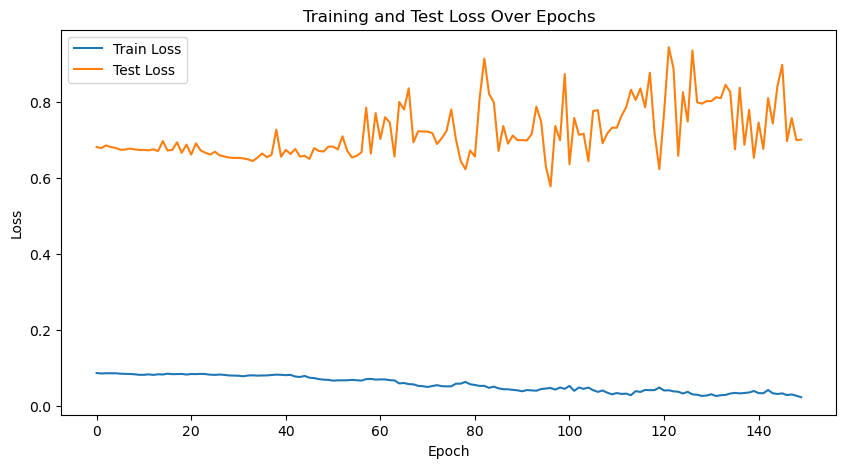

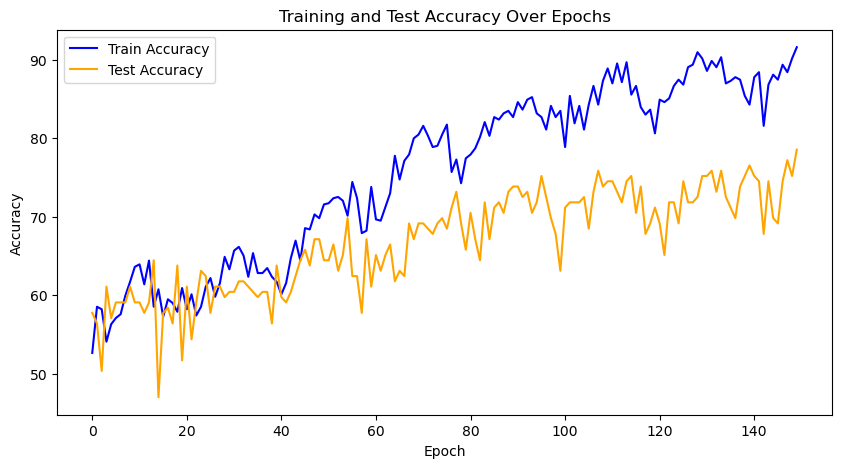

Train AUC: 0.8461
Test AUC: 0.7187


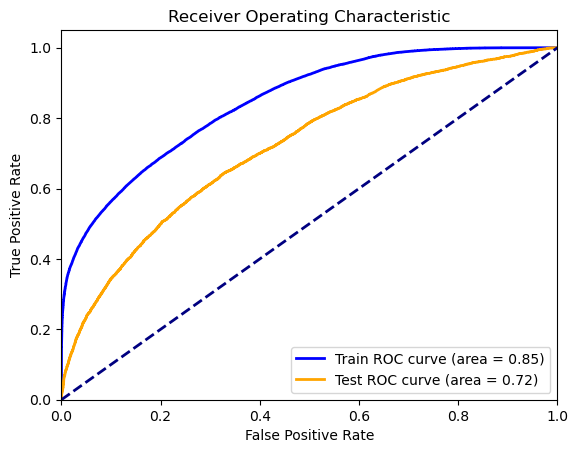

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_65605/3895469339.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(saven

Test Acc: 78.52%
Test AUC: 0.8336


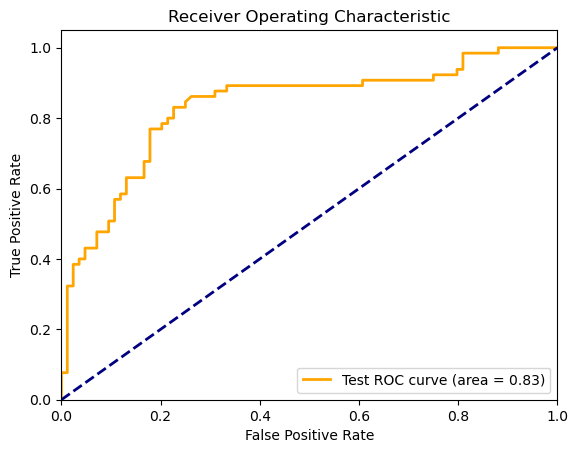

In [25]:
train_dir = './ctu-outputs/daydulo_cwt_first_stage/train'
test_dir = './ctu-outputs/daydulo_cwt_first_stage/test'
# 实例化训练器
trainer = ResNet50Trainer(train_dir, test_dir, batch_size=8, learning_rate=0.00001)

# 开始训练
trainer.train(num_epochs=150)

# 保存最优模型
trainer.save_best_model('best_model.pth')

# 测试集评估和绘制ROC曲线
trainer.test_with_best_model('best_model.pth')